# Parallel Sorting : Analysis

## Summary


## Notes


* 'dummy_sort' uses the internal Erlang lists:sort/1 method. It is provided as a baseline.


### The data :

The format is the same as for Part 1 with the addition of a 'procs' field at the beginning:

"['procs', 'alg', 'input', 'items', 'utc', 'ts', 'duration\n']"


In [6]:
with open("./perf/pperf_run.csv") as f:
    lines = f.readlines()
    for line in lines[:10]:
        items = line.split("|")
        print(items)

['procs', 'alg', 'input', 'items', 'utc', 'ts', 'duration\n']
['8', 'dummy_sort', 'constant', '10', '13 Jun 2019 23:58:48.678984', '1560470328685850', '0.000000\n']
['8', 'dummy_sort', 'constant', '100', '13 Jun 2019 23:58:48.686168', '1560470328686205', '0.000000\n']
['8', 'dummy_sort', 'constant', '1000', '13 Jun 2019 23:58:48.686667', '1560470328686701', '0.000000\n']
['8', 'dummy_sort', 'constant', '10000', '13 Jun 2019 23:58:48.687678', '1560470328687705', '0.002000\n']
['8', 'dummy_sort', 'constant', '100000', '13 Jun 2019 23:58:48.693502', '1560470328693574', '0.035000\n']
['8', 'dummy_sort', 'sorted', '10', '13 Jun 2019 23:58:48.736419', '1560470328736452', '0.001000\n']
['8', 'dummy_sort', 'sorted', '100', '13 Jun 2019 23:58:48.736891', '1560470328736920', '0.000000\n']
['8', 'dummy_sort', 'sorted', '1000', '13 Jun 2019 23:58:48.737433', '1560470328737469', '0.001000\n']
['8', 'dummy_sort', 'sorted', '10000', '13 Jun 2019 23:58:48.738705', '1560470328738746', '0.004000\n']


### Setup

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandasql import sqldf
df = pd.read_csv("./perf/pperf_run.csv", delimiter="|")
pysqldf = lambda q: sqldf(q, globals())

### Q: Did the time to sort increase proportionally to the size of the inputs?
A: Looks exponential to me.

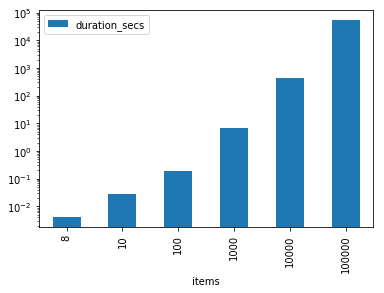

In [30]:
q = pysqldf("select items, sum(duration) as duration_secs from df group by items;")
q.plot.bar(x='items', y='duration_secs', logy=True)

### Q: Did adding more processesors and parallelizing the solution result in faster problem solving?
A: Uh oh. That looks like a big fat _NO_. In the graph below, the different colors represent the different number of processors that were enlisted by the parallelization function. The input datasets were chunked into the number of processors enlisted (from 3 to 8) and then processed in parallel via `rpc:pmap`. More on that below.

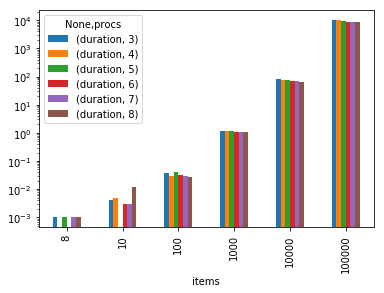

In [35]:
q = pysqldf("select items, procs, duration from df;")
q.groupby(['items', 'procs']).sum(axes='duration').unstack().plot.bar(logy=True, rot=90)

### Closeup on the items = 100000

Looks like `7` processors was the sweet spot on my machine (W510 with 8 virtual cpus). But it's interesting that the results didn't vary by all that much.

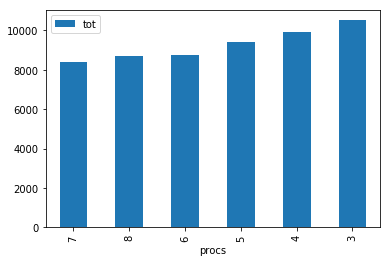

In [41]:
q = pysqldf("select items, procs, sum(duration) as tot from df where items == 100000 group by procs order by tot asc;")
q.plot.bar(x='procs', y='tot')

So the question is, where did the time get spent and are the results an artifact of how I'm testing this? The results are definitely not what I expected, so let's dig in...